In [112]:
# Set up

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import statsmodels.api as sm
from SSA import SSA
import fred

keyFile = open('FRED_api_key.txt')
FRED_api_key = keyFile.readline()

fred.key(FRED_api_key)

In [145]:
DGS10 = pd.io.json.json_normalize(fred.observations('DGS10')['observations'])
DGS1 = pd.io.json.json_normalize(fred.observations('DGS1')['observations'])

DGS10 = DGS10[~DGS10['value'].isin(['.'])]
DGS1 = DGS1[~DGS1['value'].isin(['.'])]

i = 0

F_10 = pd.to_numeric(DGS10['value'])[i:]
F_1 = pd.to_numeric(DGS1['value'])[i:]

t_10 = pd.to_datetime(DGS10['date'])[i:]
t_1 = pd.to_datetime(DGS1['date'])[i:]

VIXCLS = pd.io.json.json_normalize(fred.observations('VIXCLS')['observations'])
VIXCLS = VIXCLS[~VIXCLS['value'].isin(['.'])]

F_VIXCLS = pd.to_numeric(VIXCLS['value'])
t_VIXCLS = pd.to_datetime(VIXCLS['date'])

Text(0,0.5,'Value')

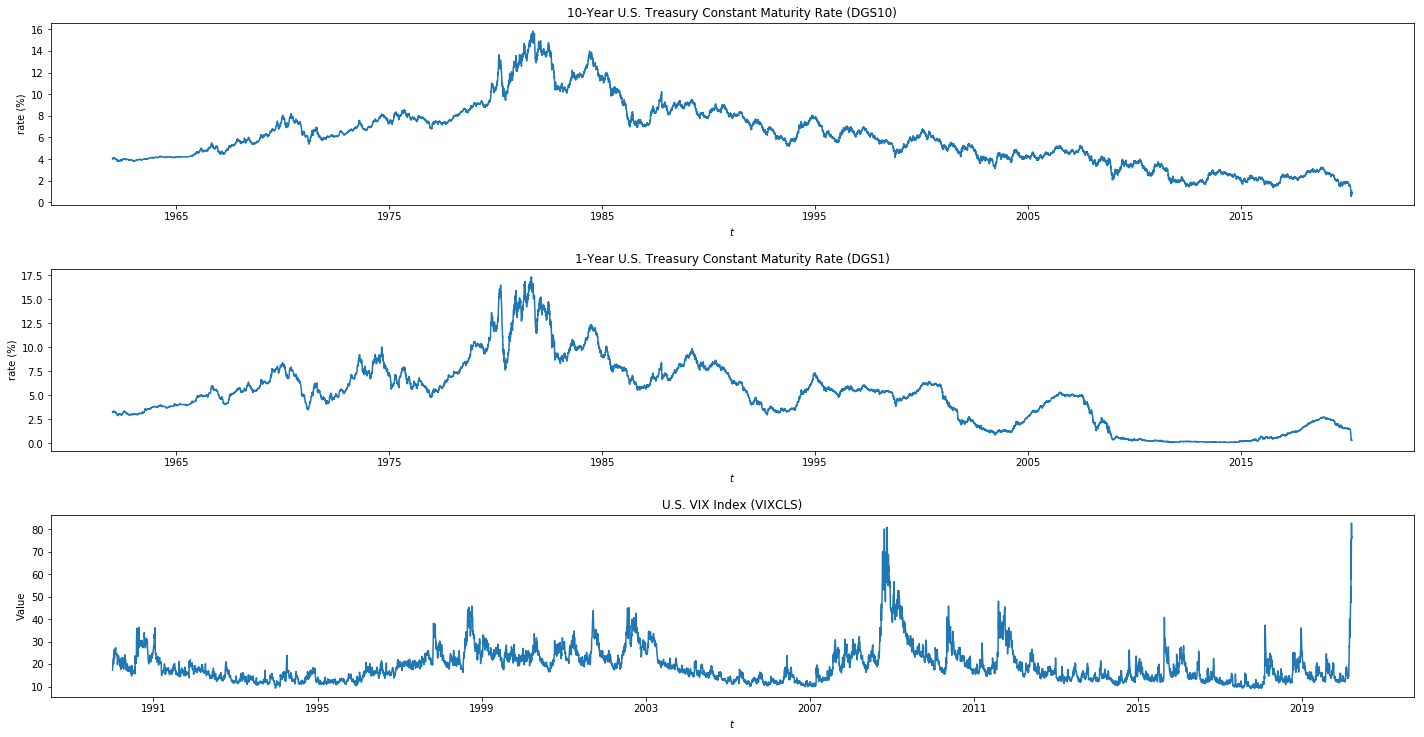

In [146]:
plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
plt.plot(t_10,F_10)
plt.title('10-Year U.S. Treasury Constant Maturity Rate (DGS10)')
plt.xlabel('$t$')
plt.ylabel('rate (%)')

plt.subplot(3, 1, 2)
plt.plot(t_1,F_1)
plt.title('1-Year U.S. Treasury Constant Maturity Rate (DGS1)')
plt.xlabel('$t$')
plt.ylabel('rate (%)')
plt.tight_layout(pad=1.5)

plt.subplot(3, 1, 3)
plt.plot(t_VIXCLS,F_VIXCLS)
plt.title("U.S. VIX Index (VIXCLS)")
plt.xlabel('$t$')
plt.ylabel('Value')


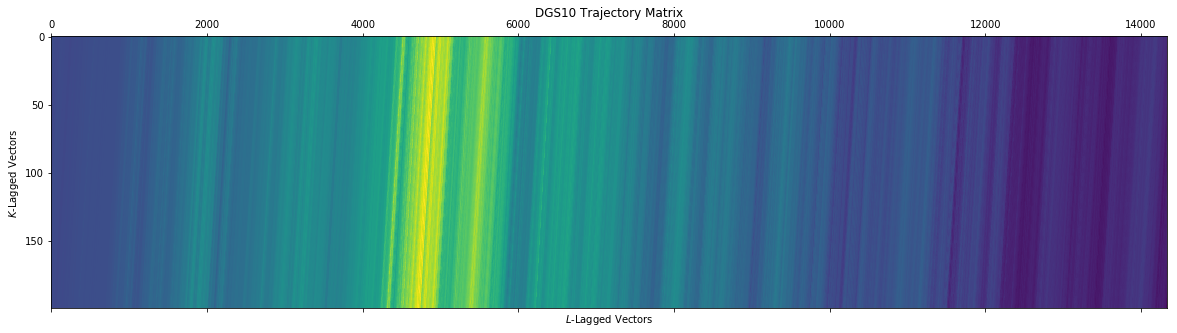

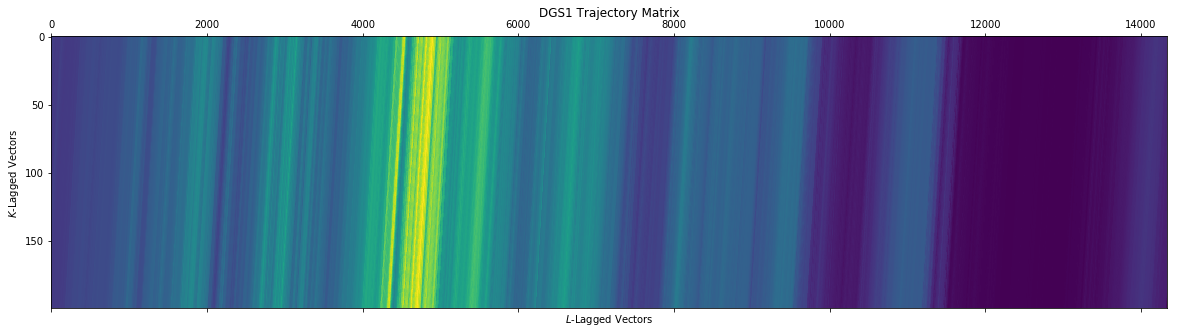

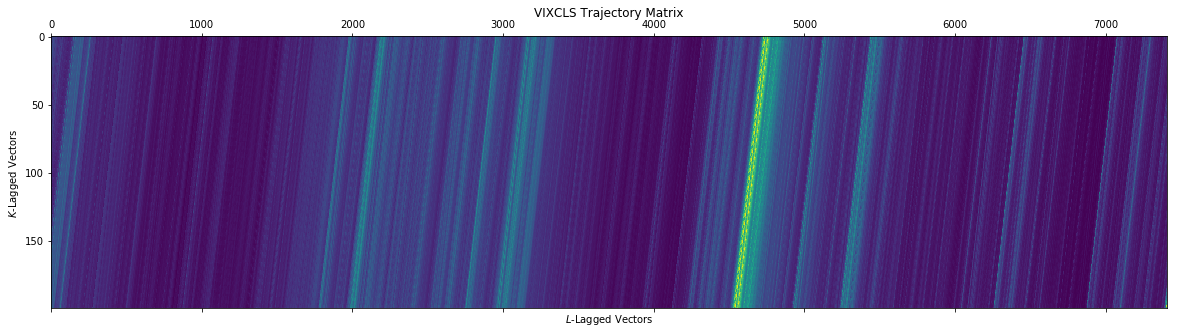

In [120]:
L = 200 # The window length for both time series
N = F_10.size
K = N - L + 1 # The number of columns in the trajectory matrix.
X = np.column_stack([F_10[i:i+L] for i in range(0,K)])

fig, ax = plt.subplots(figsize=(20,5))
ax.matshow(X, aspect='auto')
plt.xlabel('$L$-Lagged Vectors')
plt.ylabel('$K$-Lagged Vectors')
plt.title('DGS10 Trajectory Matrix');

N = F_1.size
K = N - L + 1 # The number of columns in the trajectory matrix.
X = np.column_stack([F_1[i:i+L] for i in range(0,K)])

fig, ax = plt.subplots(figsize=(20,5)) 
ax.matshow(X, aspect='auto')
plt.xlabel('$L$-Lagged Vectors')
plt.ylabel('$K$-Lagged Vectors')
plt.title('DGS1 Trajectory Matrix');

N = F_VIXCLS.size
K = N - L + 1 # The number of columns in the trajectory matrix.
X = np.column_stack([F_VIXCLS[i:i+L] for i in range(0,K)])

fig, ax = plt.subplots(figsize=(20,5)) 
ax.matshow(X, aspect='auto')
plt.xlabel('$L$-Lagged Vectors')
plt.ylabel('$K$-Lagged Vectors')
plt.title('VIXCLS Trajectory Matrix');


In [131]:
L = 200 # The window length for both time series
N = F_VIXCLS.size
K = N - L + 1 # The number of columns in the trajectory matrix.
X = np.column_stack([F_VIXCLS[i:i+L] for i in range(0,K)])

d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
U, S, V = np.linalg.svd(X)
V = V.T
# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
X_elem = np.array( [S[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

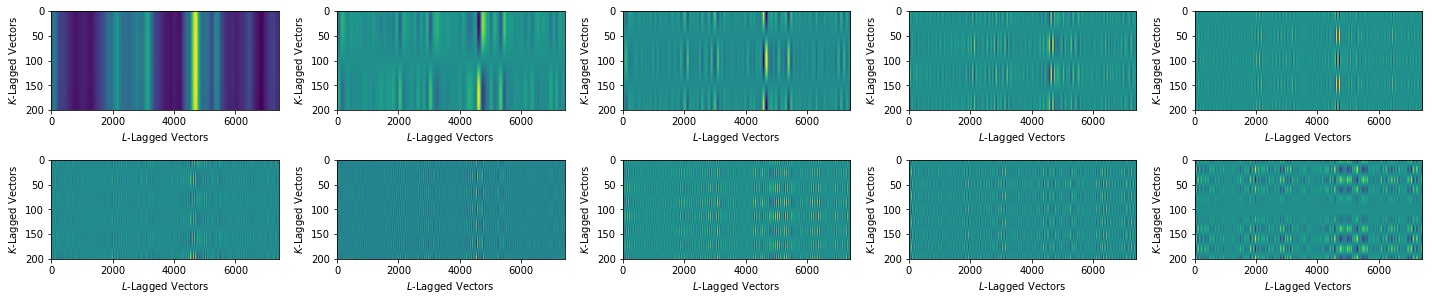

In [132]:
def plot_2d(m, title=""):
    plt.imshow(m, aspect='auto')
    plt.xticks()
    plt.yticks()
    plt.xlabel('$L$-Lagged Vectors')
    plt.ylabel('$K$-Lagged Vectors')

    
n = min(10, d)
fig, ax = plt.subplots(figsize=(20,10))
for i in range(n):
    plt.subplot(5,5,i+1)
    # title = "$\mathbf{X}_{"+str(i)+"}$"
    plot_2d(X_elem[i])
plt.tight_layout()


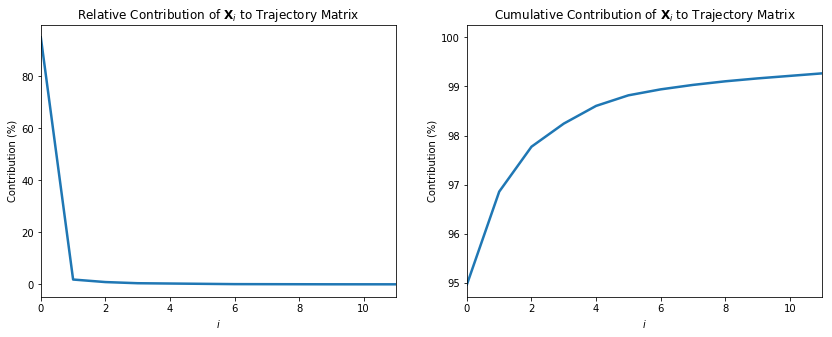

In [133]:
sigma_sumsq = (S**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(S**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((S**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

In [81]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX


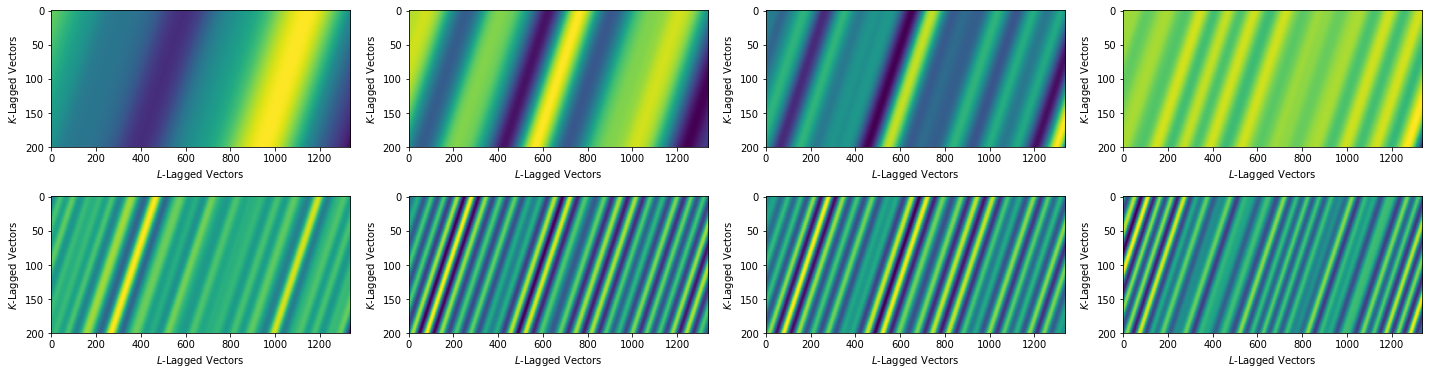

In [82]:
n = min(8, d)
fig, ax = plt.subplots(figsize=(20,10))
for j in range(0,n):
    plt.subplot(4,4,j+1)
    #title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]))
plt.tight_layout() 

In [60]:
def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
            
        fig, ax = plt.subplots(figsize=(10,10))
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        

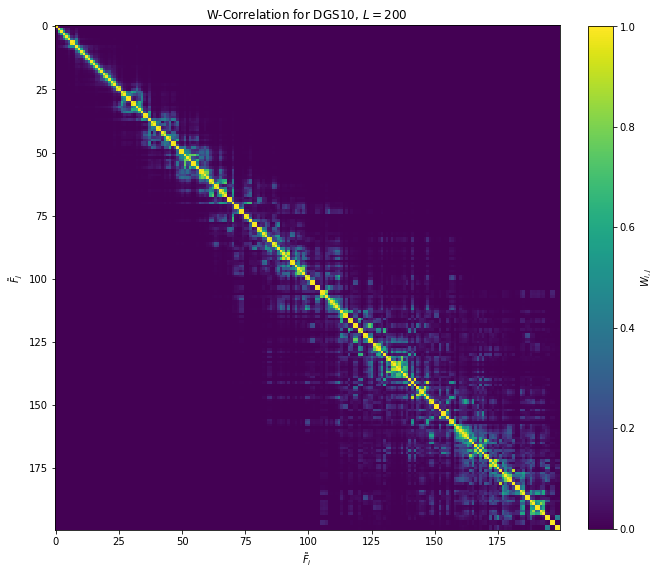

In [147]:
F_10_ssa_L = SSA(F_10, 200)
plot_wcorr(F_ssa_L)
plt.title("W-Correlation for DGS10, $L=200$");

Text(0.5,1,'$L=200$ for the DGS10')

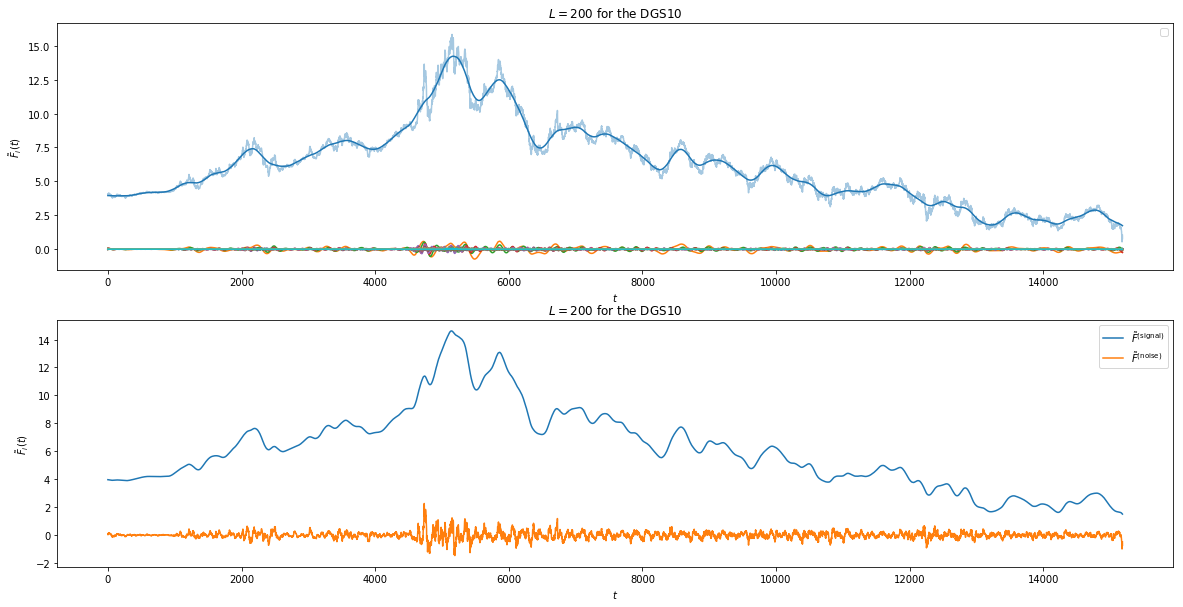

In [148]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(F_10_ssa_L.components_to_df())
F_10_ssa_L.orig_TS.plot(alpha=0.4, figsize=(20,10))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=200$ for the DGS10")
plt.legend('');

plt.subplot(2, 1, 2)
plt.plot(F_10_ssa_L.reconstruct([0,1]))
F_10_ssa_L.reconstruct(slice(2,500)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.title(r"$L=200$ for the DGS10")

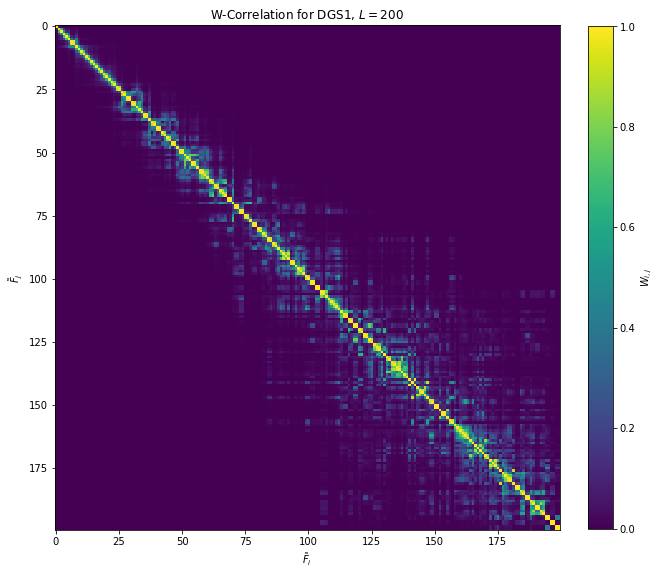

In [149]:
F_1_ssa_L = SSA(F_1, 200)
plot_wcorr(F_ssa_L)
plt.title("W-Correlation for DGS1, $L=200$");

Text(0.5,1,'$L=200$ for the DGS1')

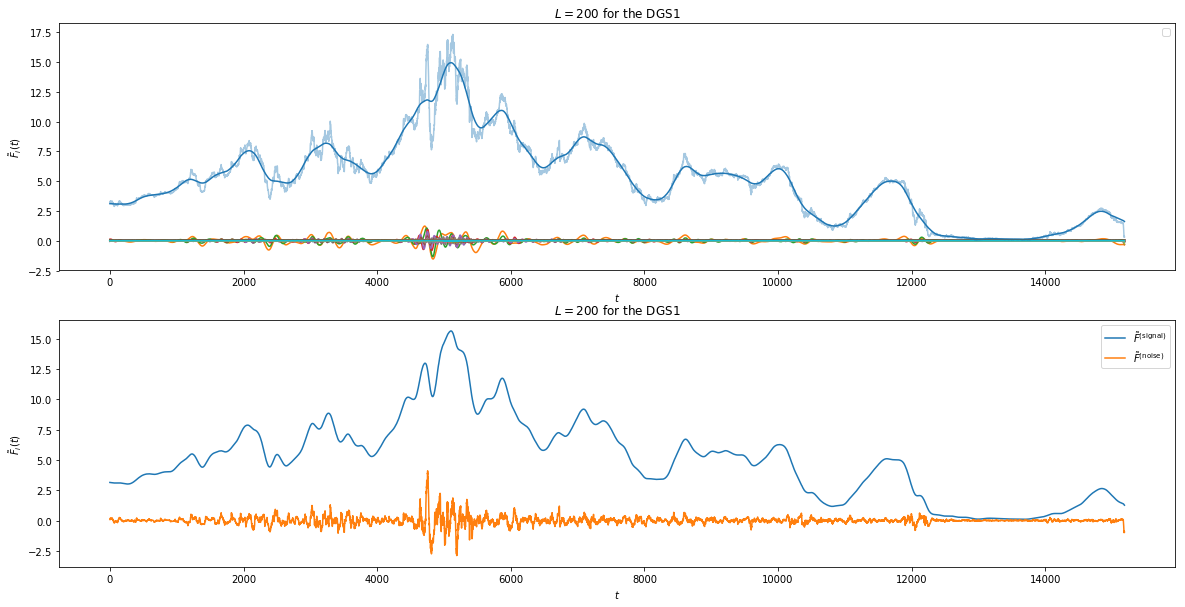

In [151]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(F_1_ssa_L.components_to_df())
F_1_ssa_L.orig_TS.plot(alpha=0.4, figsize=(20,10))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=200$ for the DGS1")
plt.legend('');

plt.subplot(2, 1, 2)
plt.plot(F_1_ssa_L.reconstruct([0,1]))
F_1_ssa_L.reconstruct(slice(2,200)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.title(r"$L=200$ for the DGS1")

In [69]:
VIXCLS = pd.io.json.json_normalize(fred.observations('VIXCLS')['observations'])
VIXCLS = VIXCLS[~VIXCLS['value'].isin(['.'])]

F_VIXCLS = pd.to_numeric(VIXCLS['value'])
t_VIXCLS = pd.to_datetime(VIXCLS['date'])

Text(0,0.5,'Value')

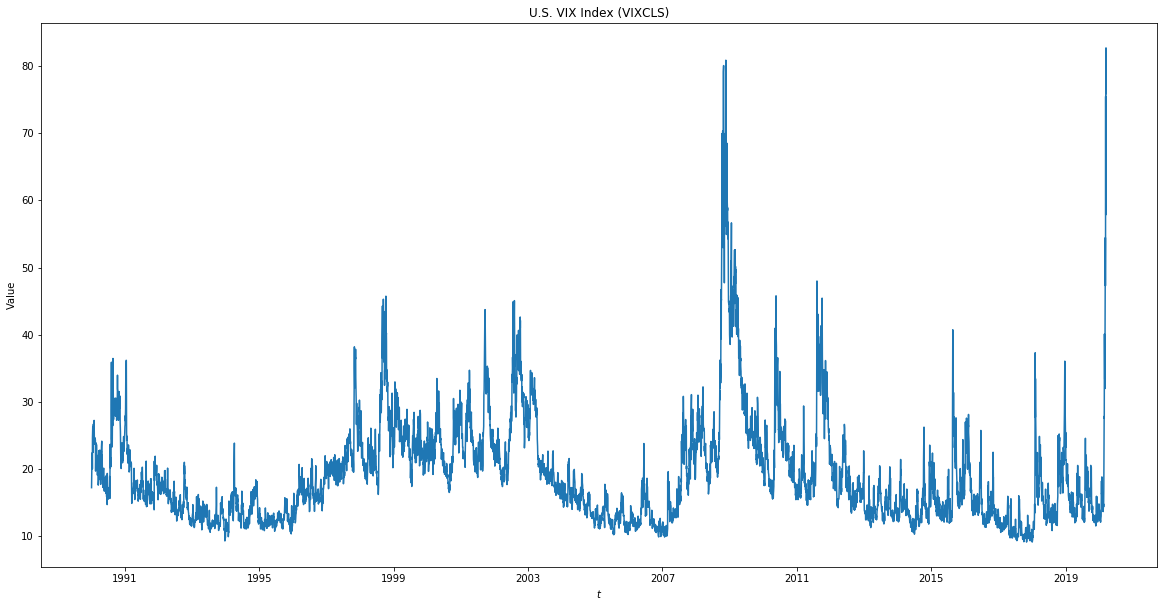

In [70]:
plt.figure(figsize=(20,10))
plt.plot(t_VIXCLS,F_VIXCLS)
plt.title("U.S. VIX Index (VIXCLS)")
plt.xlabel('$t$')
plt.ylabel('Value')

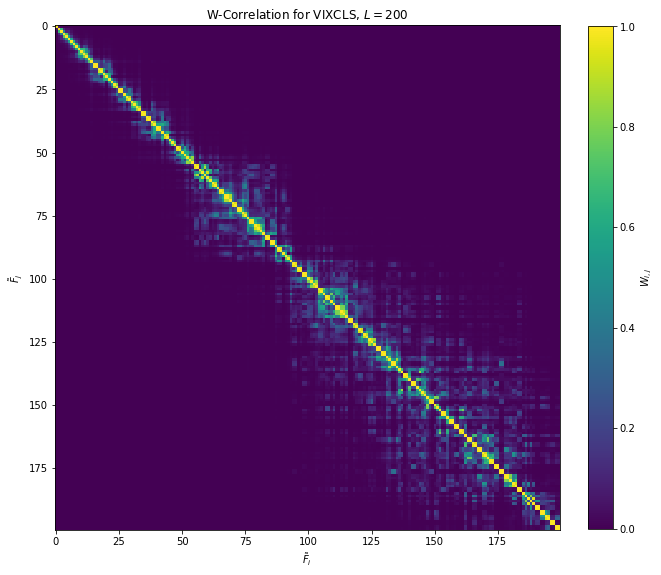

In [71]:
F_VIXCLS_ssa_L = SSA(F_VIXCLS, 200)
plot_wcorr(F_VIXCLS_ssa_L)
plt.title("W-Correlation for VIXCLS, $L=200$");

Text(0.5,1,'$L=200$ for the VIXCLS')

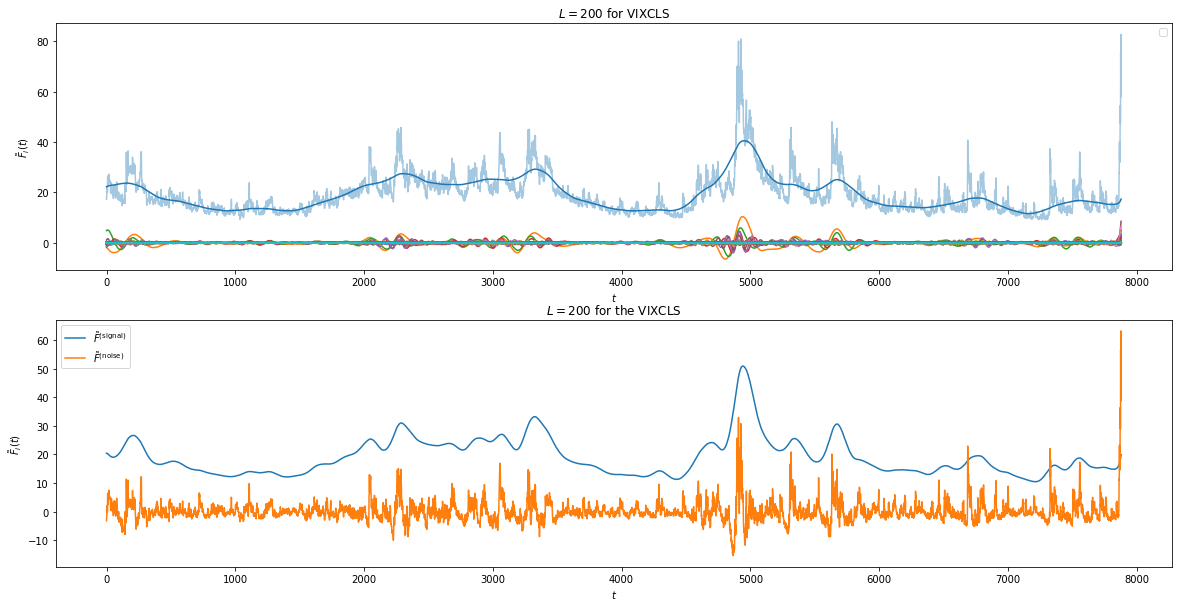

In [139]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(F_VIXCLS_ssa_L.components_to_df())
F_VIXCLS_ssa_L.orig_TS.plot(alpha=0.4, figsize=(20,10))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=200$ for VIXCLS")
plt.legend('');

plt.subplot(2, 1, 2)
plt.plot(F_VIXCLS_ssa_L.reconstruct([0,1]))
F_VIXCLS_ssa_L.reconstruct(slice(2,200)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.title(r"$L=200$ for the VIXCLS")

In [72]:
N = F_VIXCLS.size
L = 200
K = N - L + 1 # The number of columns in the trajectory matrix.
X = np.column_stack([F_VIXCLS[i:i+L] for i in range(0,K)])


In [73]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
U, S, V = np.linalg.svd(X)
V = V.T
# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
X_elem = np.array( [S[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

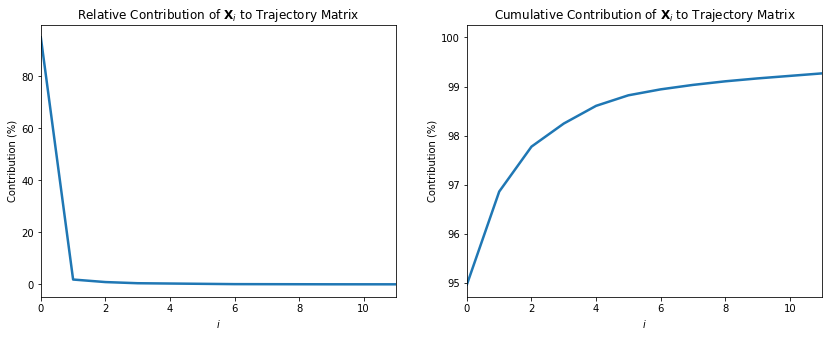

In [76]:
sigma_sumsq = (S**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(S**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((S**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");